In [1]:
## Testing Pyalgotrade Data Importing

import pandas as pd
import numpy as np
from pyalgotrade import strategy, plotter
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma, stats
from pyalgotrade.stratanalyzer import sharpe, drawdown, returns

NameError: name 'sma' is not defined

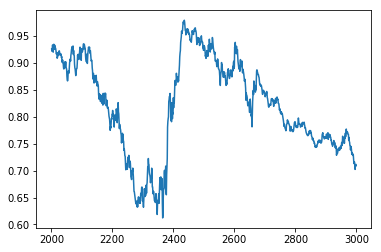

In [187]:
## Compute RSI 
import pandas
import matplotlib.pyplot as plt

aud = pandas.read_csv("AudDat8.csv")
delta = aud.Close[2000:3000].diff()
delta = delta[1:]
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

roll_up1 = up.ewm(span = 50)
roll_down1 = down.abs() 
roll_down1 = roll_down1.ewm(span = 50)

RS1 = roll_up1.mean()/roll_down1.mean()
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

roll_up2 = up.rolling(50)
roll_down2 = down.abs()
roll_down2 = roll_down2.rolling(50)

RS2 = roll_up2.mean()/roll_down2.mean()
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

usd = pandas.read_csv("AudDat8.csv")
close = usd.Close[2001:3000]
close = close
# sma = vix.Close[2000:3000]
# sma = sma.rolling(50).mean()
# vix2 = vix.Close[2001:3000]

plt.figure()
# RSI1.plot()
# RSI2.plot()
close.plot()
# vix2.plot()
sma.plot()
plt.legend(['RSI via SMA', 'AUD/USD'])
plt.show()

In [1]:
## Algo first draft

class MyStrategy(strategy,BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod ):
        super(MyStrategy, self).__init__(feed, 10000)
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getCloseDataSeries(), smaPeriod)
        self.__sd = stats.StdDev(feed[instrument].getCloseDataSeries(), smaPeriod)
        self.__vix = "vix"
        self.__vixma = ma.SMA(feed["vix"].getCloseDataSeries(), smaPeriod)
        self.__vixsd = stats.StdDev(feed["vix"].getCloseDataSeries(), smaPeriod)
        
    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        # self.info("BUY at $%.2f" % (execInfo.getPrice()))

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        # self.info("SELL %.0f USD at $%.2f" % (execInfo.getQuantity(), execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        vix = bars[self.__vix]

        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:#+self.__sd[-1]: # and vix.getPrice() < (self.__vixma[-1] + 1*self.__vixsd[-1]):# and bar.getPrice() > (self.__sma[-1]+self.__sd[-1]):
                # Enter a buy market order for 10 shares. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, 1000, True)

        # Check if we have to exit the position.
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():#-self.__sd[-1] and not self.__position.exitActive(): # and vix.getPrice() > (self.__vixma[-1] + 2*self.__vixsd[-1]):            
            self.__position.exitMarket()
            
def run_strategy(smaPeriod, vixcsv, usdcsv ):
    # Load the yahoo feed from the CSV file
    feed = yahoofeed.Feed()
    feed.addBarsFromCSV("vix", vixcsv)
    feed.addBarsFromCSV("aud", usdcsv)

    # Evaluate the strategy with the feed.
    myStrategy = MyStrategy(feed, "aud", smaPeriod)
    myStrategy.getBroker().getFillStrategy().setVolumeLimit(None)
    myStrategy.run()
    print( "Final portfolio value: $%.2f" % myStrategy.getBroker().getEquity())
    return myStrategy 

naive = run_strategy(20, "VixDatFin2.csv", "AudDatFin2.csv")

NameError: name 'strategy' is not defined

In [5]:
## Naive Implementation of Qu Strategy
class NaiveStrat(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod ):
        super(NaiveStrat, self).__init__(feed, 10000)
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getCloseDataSeries(), smaPeriod)
        self.__sd = stats.StdDev(feed[instrument].getCloseDataSeries(), smaPeriod)
        self.__vix = "vix"
        self.__vixma = ma.SMA(feed["vix"].getCloseDataSeries(), smaPeriod)
        self.__vixsd = stats.StdDev(feed["vix"].getCloseDataSeries(), smaPeriod)
        
    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        # self.info("BUY at $%.2f" % (execInfo.getPrice()))

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        # self.info("SELL %.0f USD at $%.2f" % (execInfo.getQuantity(), execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        vix = bars[self.__vix]

        # Trading Logic
        if self.__position is None:
            if vix.getPrice() < (self.__vixma[-1] - 2*self.__vixsd[-1]):# and bar.getPrice() > (self.__sma[-1]+self.__sd[-1]):
                # Go long USD when VIX price > 2*SD - Vix rolling mean; order is good till canceled.
                self.__position = self.enterLong(self.__instrument, 5000, True)

        elif vix.getPrice() > (self.__vixma[-1] + 2*self.__vixsd[-1]) and not self.__position.exitActive():
            # Short USD when VIX price < 2*SD + Vix rolling mean
            self.__position.exitMarket()
            
def run_strategy(smaPeriod, vixcsv, usdcsv):
    # Load the yahoo feed from the CSV file
    feed = yahoofeed.Feed()
    feed.addBarsFromCSV("vix", vixcsv)
    feed.addBarsFromCSV("aud", usdcsv)

    # Evaluate the strategy with the feed.
    myStrategy = NaiveStrat(feed, "aud", smaPeriod)
    myStrategy.getBroker().getFillStrategy().setVolumeLimit(None)
    # myStrategy.run()
    # print( "Final portfolio value: $%.2f" % myStrategy.getBroker().getEquity())
    return myStrategy 

def printMetrics(strat):
    returnsAnalyzer = returns.Returns()
    strat.attachAnalyzer(returnsAnalyzer)
    sharpeAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeAnalyzer)
    drwdwnAnalyzer = drawdown.DrawDown()
    strat.attachAnalyzer(drwdwnAnalyzer)
    
    strat.run()
    
    eq = strat.getBroker().getEquity()
    cumret = returnsAnalyzer.getCumulativeReturns()[-1]*100
    shrp = sharpeAnalyzer.getSharpeRatio(0.01)
    drw = drwdwnAnalyzer.getMaxDrawDown()*100
    
    print( "Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%" 
          % (eq, cumret, shrp, drw) ) 

naive = run_strategy(15, "VixDatFin2.csv", "AudDatFin2.csv")

printMetrics(naive)
# returnsAnalyzer = returns.Returns()
# naive.attachAnalyzer(returnsAnalyzer)
# sharpeAnalyzer = sharpe.SharpeRatio()
# naive.attachAnalyzer(sharpeAnalyzer)
# drwdwnAnalyzer = drawdown.DrawDown()
# naive.attachAnalyzer(drwdwnAnalyzer)

# naive.run() 

# print( naive.getBroker().getEquity() )
# print( returnsAnalyzer.getCumulativeReturns()[-1]*100 )
# print( sharpeAnalyzer.getSharpeRatio(0.01) )
# print( drwdwnAnalyzer.getMaxDrawDown() )
# print( drwdwnAnalyzer.getLongestDrawDownDuration() )

Final Value: $10101.50 // Cumulative Return: 1.02% // Sharpe: -0.71  // Max Drawdown: 2.12%


In [4]:
## Analytics Loop
## Run strategy from 06-29-2012 to 07-01-2016
analytics = {
    "equity":[],
    "cumret":[],
    "sharpe":[],
    "drwdwn":[],
    "drwdur":[]
}

for i in range(1,47):
    
    usdstr = "QuTrain" + "/" + "UsdTrain" + str(i) + ".csv"
    vixstr = "QuTrain" + "/" + "VixTrain" + str(i) + ".csv"
    strat = run_strategy(15, vixstr, usdstr)
    
    returnsAnalyzer = returns.Returns()
    strat.attachAnalyzer(returnsAnalyzer)
    sharpeAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeAnalyzer)
    drwdwnAnalyzer = drawdown.DrawDown()
    strat.attachAnalyzer(drwdwnAnalyzer)
    
    strat.run()
    
    eq = strat.getBroker().getEquity()
    cret = returnsAnalyzer.getCumulativeReturns()[-1]
    shrp = sharpeAnalyzer.getSharpeRatio(0.01)
    drw1 = drwdwnAnalyzer.getMaxDrawDown()
    drw2 = drwdwnAnalyzer.getLongestDrawDownDuration()
    
    analytics["equity"].append(eq)
    analytics["cumret"].append(cret)
    analytics["sharpe"].append(shrp)
    analytics["drwdwn"].append(drw1)
    analytics["drwdur"].append(drw2)
    
    print("Final Value: $%.2f // Cumulative Return: %.2f%% // Sharpe: %.2f  // Max Drawdown: %.2f%%  " % (eq, cret*100, shrp, drw1*100))


Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 560 days
Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 578 days
Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 593 days
Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 609 days
Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 624 days
Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 642 days
Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 657 days
Final Value: $10016.00 // Cumulative Return: 0.16% // Sharpe: -1.14  // Max Drawdown: 1.44%  // Max DD Duration: 673 days
Final Value: $10031.00 /

In [7]:
# import matplotlib.pyplot as plot
# plot.hist(analytics["equity"], bins=50)
# plot.show()
# plot.hist(analytics["sharpe"], bins=50)
# plot.show()
# plot.hist(analytics["equity"], bins=50)
# plot.show()
# print(sum(analytics["equity"])/46, sum(analytics["cumret"])/46, sum(analytics["sharpe"])/46, sum(analytics["drwdwn"])/46)
def hi():
    tmp = [1,2,3,4]
    return tmp
hi()

[1, 2, 3, 4]